In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

VIDEO_PATH = './VID_20230515_105413.mp4'
DOWNSCALE_FACTOR = 80 # percent of original size
FRAMES_PER_TIME_WINDOW = 15
FRAMERATE = 60 # frames per second
TIME_PER_FRAME = 1 / FRAMERATE # seconds
CAMERA_DIMENSIONS = (1080, 1920) # (height, width)
FOOSBALL_WIDTH = 0.7 # meters

In [2]:
video = cv2.VideoCapture(VIDEO_PATH)

In [3]:
def get_biggest_contour_center(frame):
    biggest_area = 0
    biggest_contour = None
    contours, _ = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > biggest_area:
            biggest_area = area
            biggest_contour = cnt

    if biggest_contour is None:
        return None
    
    M = cv2.moments(biggest_contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return cX, cY


def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

def get_pixel_to_meter_ratio(frame, mask_field_low, mask_field_high):

    mask = get_mask(frame, mask_field_low, mask_field_high)

    mask = cv2.dilate(mask, np.ones((10, 10), np.uint8), iterations=6)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #We get the biggest countour we find, should be the field
    biggest_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > biggest_area:
            biggest_area = area
            biggest_contour = cnt


    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)
    rect = cv2.minAreaRect(biggest_contour)
    foosball_width_px = rect[1][1]
    pixel_to_meter_ratio = FOOSBALL_WIDTH / foosball_width_px

    return pixel_to_meter_ratio
    
def get_goals(frame, mask_goals_low, mask_goals_high):
    mask_goals = get_mask(frame, mask_goals_low, mask_goals_high)
    cv2.imshow('mask_goals', mask_goals)
    contours, _ = cv2.findContours(mask_goals, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    goals = []

    # Get the biggest 2 contours, should be the goals    
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    goal1, goal2 = cv2.boundingRect(contours[-1]), cv2.boundingRect(contours[-2])

    goal_left = goal1 if goal1[0] < goal2[0] else goal2
    goal_right = goal1 if goal1[0] > goal2[0] else goal2

    return goal_left, goal_right
    


def check_if_goal(frame, mask_goals_low, mask_goals_high, ball_center):
    goal_left, goal_right = get_goals(frame, mask_goals_low, mask_goals_high)

    x1, y1, w1, h1 = goal_left
    if x1 < ball_center[0] < x1 + w1 and y1 < ball_center[1] < y1 + h1:
        return 0
    
    x2, y2, w2, h2 = goal_right
    if x2 < ball_center[0] < x2 + w2 and y2 < ball_center[1] < y2 + h2:
        return 1
    
    return None
        



def get_mask(frame, mask_range_low, mask_range_high):
    width = int(frame.shape[1] * DOWNSCALE_FACTOR / 100)
    height = int(frame.shape[0] * DOWNSCALE_FACTOR / 100)
    dim = (width, height)
    frame = cv2.resize(frame, dim, interpolation=None)

    frame = cv2.blur(frame, (5, 5))
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(frame, mask_range_low, mask_range_high)
    
    mask = cv2.erode(mask, np.ones((8, 8), np.uint8), iterations=2)

    mask = cv2.dilate(mask, np.ones((8, 8), np.uint8), iterations=6)

    return mask

def get_ball_velocity(centers_x, centers_y, pixel_to_meter_ratio):
    if np.all(np.isnan(centers_x)) or np.all(np.isnan(centers_y)):
     return 0

    # Interpolate missing positions
    nans, x= nan_helper(centers_x)
    centers_x[nans]= np.interp(x(nans), x(~nans), centers_x[~nans])
    nans, y= nan_helper(centers_y)
    centers_y[nans]= np.interp(y(nans), y(~nans), centers_x[~nans])

    positions_offset_x = np.abs(centers_x[1:] - centers_x[:-1])
    positions_offset_y = np.abs(centers_y[1:] - centers_y[:-1])

    velocities_x = positions_offset_x / TIME_PER_FRAME
    velocities_y = positions_offset_y / TIME_PER_FRAME

    velocities = np.sqrt(velocities_x**2 + velocities_y**2)

    max_velocity = np.max(velocities) # pixel per second

    max_velocity_ms = max_velocity * pixel_to_meter_ratio # meter per second

    return max_velocity_ms


def track():
    #! TO REMOVE
    video = cv2.VideoCapture(VIDEO_PATH)
    video.set(cv2.CAP_PROP_POS_FRAMES, 12000)

    mask_ball_low = (23, 131, 133)
    mask_ball_high = (33, 251, 252)

    mask_field_low = (33, 20, 0)
    mask_field_high = (92, 255, 255)

    mask_goals_low = (75, 170, 9)
    mask_goals_high = (116, 255, 158)

    centers_x = np.zeros(FRAMES_PER_TIME_WINDOW)
    centers_y = np.zeros(FRAMES_PER_TIME_WINDOW)

    i = 0
    first_frame = True
    goal_cool_down = 0

    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        if first_frame:
            pixel_to_meter_ratio = get_pixel_to_meter_ratio(frame, mask_field_low, mask_field_high)
            first_frame = False
        cv2.imshow('Frame', frame)

        ball_mask = get_mask(frame, mask_ball_low, mask_ball_high)
        cv2.imshow('Ball mask', ball_mask)
        centers = get_biggest_contour_center(ball_mask)
        if centers:
            cX, cY = centers
            centers_x[i] = cX
            centers_y[i] = cY
            
            if goal_cool_down == 0:
                goal = check_if_goal(frame, mask_goals_low, mask_goals_high, (cX, cY))
                if goal is not None:
                    print(goal)

                    goal_cool_down = FRAMERATE * 5 # number of frames in 5 seconds
            
        else:
            centers_x[i] = np.nan
            centers_x[i] = np.nan

        if goal_cool_down > 0:
            goal_cool_down -= 1
            
        i = i + 1
        if (i == FRAMES_PER_TIME_WINDOW - 1):
            max_velocity_ms = get_ball_velocity(centers_x, centers_y, pixel_to_meter_ratio)
            # reset
            i = 0
        
        key = cv2.waitKey(30)
        if key == ord('q') or key == 27:
            break
    
    # video.release()
    # cv2.destroyAllWindows()



In [4]:
track()

1
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34


(1409, 273, 94, 228)
(79, 251, 92, 226)


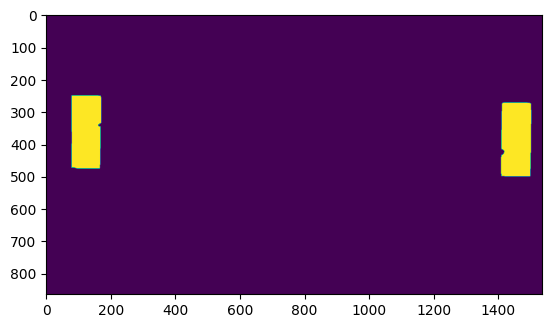

In [32]:
mask_goals_low = (75, 170, 9)
mask_goals_high = (116, 255, 158)

mask_ball_low = (23, 131, 133)  
mask_ball_high = (33, 251, 252)

video = cv2.VideoCapture(VIDEO_PATH)
video.set(cv2.CAP_PROP_POS_FRAMES, 15000)
ret, frame = video.read()

mask_goals = get_mask(frame, mask_goals_low, mask_goals_high)
mask_ball = get_mask(frame, mask_ball_low, mask_ball_high)
center_ball = get_biggest_contour_center(mask_ball)

contours, _ = cv2.findContours(mask_goals, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
goals = []

# Get the biggest 2 contours, should be the goals    
contours = sorted(contours, key=lambda x: cv2.contourArea(x))
goal1, goal2 = cv2.boundingRect(contours[-1]), cv2.boundingRect(contours[-2])

goal_left = goal1 if goal1[0] < goal2[0] else goal2
goal_right = goal1 if goal1[0] > goal2[0] else goal2

plt.imshow(mask_goals)


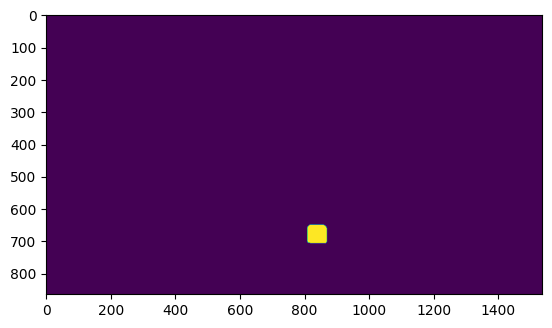

In [7]:
plt.imshow(mask_ball)